In [1]:
import cv2
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from shapely.geometry import Polygon

from inference_utils.tiled_segmentation import WindowReadyImage
from inference_utils.yolact_inference import YOLACTModel

%matplotlib inline

In [2]:
def read_image(img_p: str) -> np.ndarray:
    _img = cv2.imread(img_p, cv2.IMREAD_COLOR)
    assert _img is not None, img_p
    return cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)

In [6]:
samplep = '/media/alexey/SSDDataDisk/datasets/walruses/raw/markup/191.json'

with open(samplep, 'r') as jf:
    markup_data = json.load(jf)

In [7]:
markup_data[0]

{'id': 1,
 'segmentation_poly': [[714.0,
   44.5,
   732.0,
   40.5,
   736.0,
   34.5,
   742.5,
   33.0,
   743.5,
   27.0,
   739.5,
   23.0,
   744.5,
   10.0,
   743.0,
   0.5,
   632.5,
   1.0,
   655.0,
   27.5,
   672.0,
   37.5,
   687.0,
   43.5]],
 'bbox': [632.5, 0.5, 112.0, 44.0, 0.0],
 'category_id': 1,
 'tracker_id': None,
 'segmentation': None,
 'comment': '',
 'is_key_frame': True,
 'orientation': None,
 'type': 'poly',
 'tag_list': []}

In [77]:
img = np.ones((100, 100), dtype=np.uint8)*255

contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours[0].shape

(396, 1, 2)

In [3]:
from shapely import ops
from shapely.ops import voronoi_diagram
d = markup_data[9]
poly = Polygon(np.array(d['segmentation_poly']).reshape(-1, 2))

ppoints = np.array(poly.exterior.xy).T.astype(np.float32)
box = cv2.boundingRect(ppoints)
ppoints -= box[:2]
ppoints = np.expand_dims(ppoints, axis=1).astype(np.int0)

mask = np.zeros((box[3], box[2]), dtype=np.uint8)
mask = cv2.drawContours(mask, [ppoints], 0, 255, -1)
dres = cv2.distanceTransform(mask, cv2.DIST_L2, 5, cv2.DIST_LABEL_PIXEL)
_, _, _, (cx, cy) = cv2.minMaxLoc(dres, None)

print(cx, cy)

plt.figure(figsize=(8, 8))
plt.imshow(mask)
plt.show()

NameError: name 'markup_data' is not defined

In [4]:
yolact_inference = YOLACTModel()

Config not specified. Parsed yolact_im700_config from the file name.

Loading model... Done.


In [5]:
sample_image = read_image('/media/alexey/SSDDataDisk/datasets/walruses/raw/images/86.jpg')
pred_sample = WindowReadyImage(sample_image, yolact_inference, 700)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


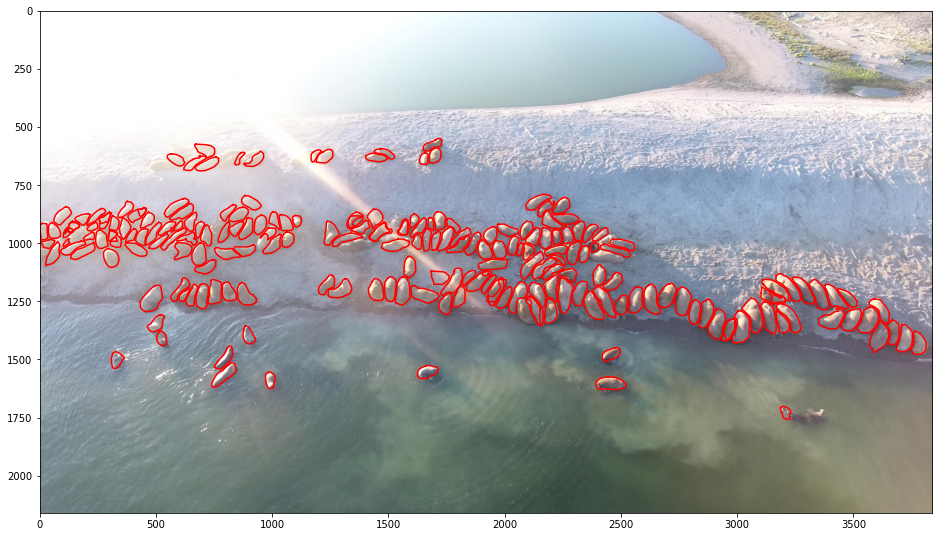

In [6]:
import shapely


plt.figure(figsize=(16, 10))

plt.imshow(sample_image)

for p in pred_sample.detections:
    x, y = p.poly.exterior.xy
    plt.plot(x, y, c="red")
plt.show()

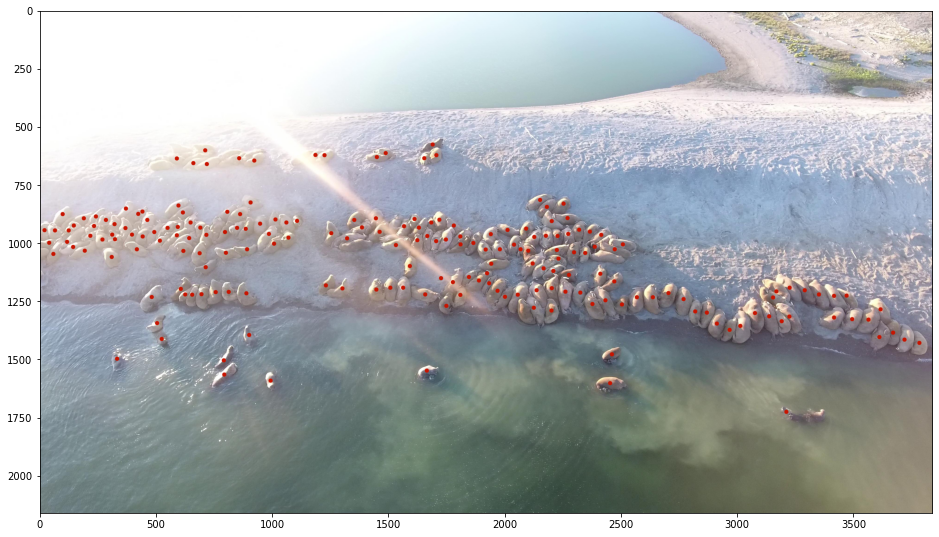

In [7]:
viz_img = sample_image.copy()

for p in pred_sample.get_points():
    viz_img = cv2.circle(viz_img, tuple(p), 9, (200, 20, 0), -1)

plt.figure(figsize=(16, 10))
plt.imshow(viz_img)
plt.show()